In [1]:
import clip
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import wandb

C:\Users\Ldori\miniconda3\envs\SketchAI\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load('ViT-B/32', device, jit=False)

In [3]:
labels = os.listdir('quickdraw-dataset/rendered')
images = []
for label in labels:
    ims = os.listdir(f"quickdraw-dataset/rendered/{label}")
    ims = [torch.load(f"quickdraw-dataset/rendered/{label}/{name}") for name in ims]
    images.append(ims)
labels = [x.replace('_', ' ') for x in labels]

key


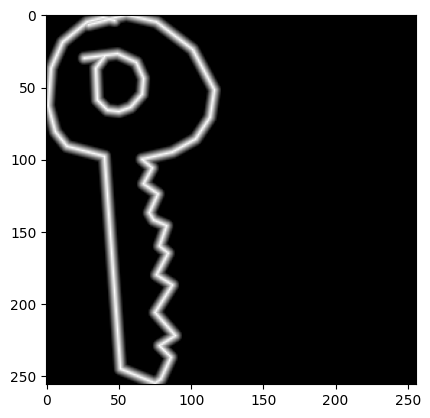

In [4]:
idx = 160
print(labels[idx])
plt.imshow(images[idx][7])

In [5]:
# im = torch.permute(images[0][0], (2, 0, 1))
# im = torch.stack([im], dim=0)
# im = augment_trans(im)
# model.encode_image(im.to(device)).shape
# #im = torch.permute(torch.squeeze(im, dim=0), (1, 2, 0))
# #plt.imshow(im)

In [6]:
model.encode_text(clip.tokenize(['hello world']).to(device)).shape

torch.Size([1, 512])

In [7]:
#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float() 

def get_batch(batch_size):
    # Pick batch_size classes at random to sample from
    indexes = list(range(len(labels)))
    indexes = random.sample(indexes, batch_size)
    
    xs = []
    ys = []
    for idx in indexes:
        label = labels[idx]
        
        # Pick random image in this class
        img = images[idx][random.randint(0, len(images[idx])-1)]
        
        xs.append(img)
        ys.append(label)
        
    return (xs, ys)

def get_loss(model, xs, ys):
    augment_trans = transforms.Compose([
        transforms.RandomPerspective(fill=0, p=1, distortion_scale=0.5),
        transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])
    n = len(xs)
    
    # Encode text into latent space
    text_input = clip.tokenize(ys).to(device)
    text_features = model.encode_text(text_input) # n x 512
    
    # Encode image into latent space
    im_batch = []
    for im in xs:
        im2 = torch.permute(im, (2, 0, 1))
        im2 = augment_trans(im2)
        im_batch.append(im2)
    im_batch = torch.stack(im_batch, dim=0)
    im_batch = im_batch.to(device)
    image_features = model.encode_image(im_batch) # n x 512
    
    # Compute logits (n x n similarity scores)
    logits = torch.inner(image_features, text_features) # n x n
    
    # Compute loss
    labels = torch.arange(n).to(device)
    ce = nn.CrossEntropyLoss()
    loss_i = ce(logits, labels)
    loss_t = ce(logits.T, labels)
    loss = (loss_i + loss_t) / 2
    return loss

def train(model, num_iters, batch_size):
    if device == "cpu":
        model.float()
    else:
        clip.model.convert_weights(model)
    
    optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
    for i in range(num_iters):
        optimizer.zero_grad()
        
        xs, ys = get_batch(batch_size)
        loss = get_loss(model, xs, ys)
        wandb.log({
            'iteration': i,
            'loss': loss,
        })
        loss.backward()
        
        if i%25 == 0:
            torch.save({
                'iteration': i,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, f"finetuned-clip-models/model_{i}.pt")
        
        if device == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

In [8]:
wandb.init(project="clip-finetuning")

wandb: Currently logged in as: whalevomit. Use `wandb login --relogin` to force relogin


In [9]:
train(model, 1000, 50)

KeyboardInterrupt: 